## Aim

Replicate (with minimal looking back and forth) an MCMC occurrence rate computation, then do an ABC one to compare.

In [13]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import emcee
from scipy import optimize

Looking at the `emcee` documentation, we need to define

- the number of walkers (let's say 5)
- the number of parameters we're trying to fit (3 - F0, alpha, beta of the powerlaw)
- a log-probability or log-density (take the log of the powerlaw), which may depend on some other positional arguments.

The usual powerlaw is

$$\lambda(p, r|\theta) = F_0 \frac{(\alpha + 1) r^\alpha}{r_{max}^{\alpha + 1} - r_{min}^{\alpha + 1}} \frac{(\beta + 1) p^\beta}{p_{max}^{\beta + 1} - p_{min}^{\beta + 1}}$$

and so a log-_like_ estimate (we could just do it numerically but that'd be vulnerable to instability) would be

$$\log \lambda(p, r|\theta) = \log F_0 + \alpha \log r - \log(r_{max}^{\alpha + 1} - r_{min}^{\alpha + 1}) + \beta \log p - \log(p_{max}^{\beta + 1} - p_{min}^{\beta + 1})$$.

We'll be walking over (F0, alpha, beta) parameter space, so we want to write a function that'll evaluate this log likelihood at a specific point. To do that, we need to get the (period, radius) pairs for every planetary candidate. (you need something to take the likelihood of). To that end, let's import data as in the AAS 2019 occurrence rate tutorial.

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_GK.txt"
pcCatalog = "koiCatalogs/dr25_GK_PCs.csv"
# stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)

In [9]:
print(*base_kois.columns, sep=', ')

kepid_x, kepoi_name, koi_tce_plnt_num, koi_pdisposition, koi_score, koi_period, koi_max_mult_ev, koi_prad, koi_prad_err1, koi_prad_err2, koi_ror, koi_ror_err1, koi_ror_err2, radius, radius_err1, radius_err2, teff, corrected_prad, corrected_prad_err1, corrected_prad_err2, rowid, kepid_y, fpp_koi_period, fpp_prob, fpEffectiveness, obsFpRate, reliability, fpp_prob_use, totalReliability


The data we want are in `koi_period`, `corrected_prad`, `corrected_prad_err1` and `corrected_prad_err2`. Alternatively, `koi_prad` may have the relevant data instead (the tutorial switches between them but has corrected by default). For the sake of trying to replicate results, we'll use `corrected`. The tutorial also imports stellar data, but that's not relevant at this point.

Let's try and set up a log-likelihood over all samples, using the power of higher order functions.

In [37]:
def get_log_prob_fn(radii, periods):
    '''
    Arguments
    ---------
    radii : ndarray
    Radii of KOIs.
    
    period : ndarray
    Periods of KOIs.
    
    These are assumed to have the same length and have corresponding indices.
    
    Returns
    -------
    log_prob_fn : callable
    The log-probability that emcee takes as input.
    '''
    assert len(radii) == len(periods), "mismatched input data"
    r_min, r_max = np.min(radii), np.max(radii)
    p_min, p_max = np.min(periods), np.max(periods)
    def log_prob_fn(theta):
        F0, alpha, beta = np.abs(np.array(theta))
        log_prob = len(radii) * (np.log(F0) - np.log(r_max ** (alpha + 1) - r_min ** (alpha + 1)) 
                                 - np.log(p_max ** (beta + 1) - p_min ** (beta + 1)))
        log_prob += alpha * np.sum(np.log(radii)) + beta * np.sum(np.log(periods))
        if np.isnan(log_prob):
            return -np.inf
        return log_prob
    
    return log_prob_fn

The tutorial removes some of the datapoints and does some more sophisticated analysis, but just for a baseline let's not do that. Instead, we'll just call `emcee` now. The Dan Foreman-Mackey blogpost that does this (dfm.io/posts/exopop) first minimizes to get the peak, then runs MCMC around that peak, so let's do that too.

In [38]:
log_prob = get_log_prob_fn(base_kois['corrected_prad'], base_kois['koi_period'])
res = optimize.minimize(lambda theta: -log_prob(theta), np.array([1, 2, 3]))
print(res.x)

[ 9.36804476e+06 -7.57628256e-04  1.77904875e-05]


In [39]:
pos = np.array([np.array(res.x) + np.random.normal(0, 1e-4, (3,)) for _ in range(16)])
sampler = emcee.EnsembleSampler(16, 3, log_prob) 
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()
pos, _, _ = sampler.run_mcmc(pos, 4000)

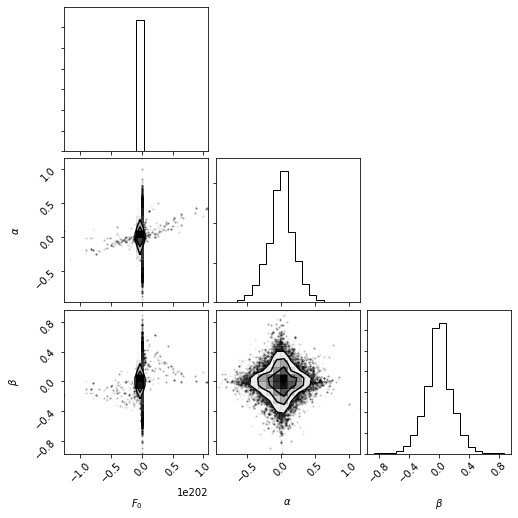

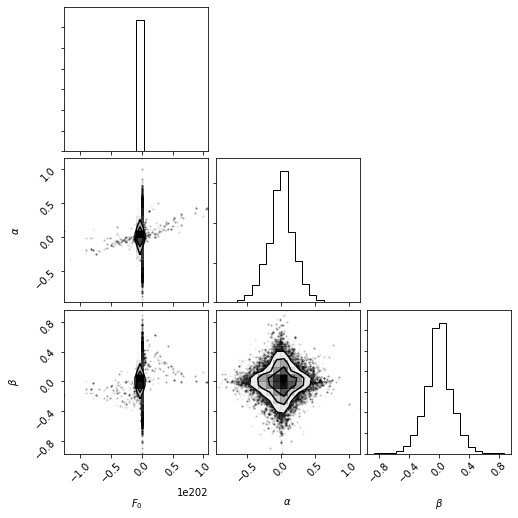

In [40]:
import corner
corner.corner(sampler.flatchain, labels=[r'$F_0$', r'$\alpha$', r'$\beta$'])

That's...interesting. Definitely looks like some kind of Gaussian spread, and $\alpha$ and $\beta$ have some correlation going on, but the scale of $F_0$ is all over the place and the actual value of $F_0$ doesn't seem to have walked around at all. Also, $\alpha$ and $\beta$ both seem to be centered around 0, which is strange.

First theory: this is due to anomalous data points. The original tutorial and the Foreman-Mackey blog post both take out some data points for not being in the relevant regions.

In [44]:
len(base_kois['corrected_prad'])

1939